# BigDL REINFORCE Policy Gradient

## 1. Init Environment and define some utilities

In [1]:
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
#import torchfile

In [2]:
from bigdl.dataset.transformer import Sample
from bigdl.nn.layer import *
from bigdl.util.common import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *

#from rl.criterion import *

init_engine()

In [3]:
def to_RDD(X, y):
    def to_sample(x, y):
        input_tensor = JTensor.from_ndarray(x)
        values = np.array([y[1]])
        indices = np.array([y[0]])
        shape = np.array([2])
        target_tensor = JTensor.sparse(values, indices, shape, bigdl_type="float")
        return Sample.from_jtensor(input_tensor, target_tensor)
    return sc.parallelize(X).zip(sc.parallelize(y)).map(lambda x: to_sample(x[0], x[1]))

In [4]:
def normalize(advantages, smallEps=1e-8):
    return (advantages - advantages.mean())/(advantages.std() + smallEps)

## 2. Define Agent and Trajectory Buffer

In [5]:
class PGAgent:
    def __init__(self, state_size, action_size, gamma=0.95):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma  # discount rate
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()

        model.add(Linear(self.state_size, 10))
        model.add(Tanh())

        #model.add(Linear(24, 24))
        #model.add(ReLU())

        model.add(Linear(10, 2))
        model.add(SoftMax())
        return model

    def action_sampler(self,out):
        #return 1 if result > np.random.random() else 0
        return np.random.choice([0,1], p=out)
        
    def act(self, state):
        out = self.model.forward(state)
        #print out
        return self.action_sampler(out)
        

In [6]:
class Trajectory:
    def __init__(self,obs,actions,rewards,total_steps):
        self.obs = obs
        self.actions = actions
        self.rewards = rewards
        self.steps = total_steps
        self.total_reward = rewards.sum()
    
    def get_summary(self):
        return {"total_reward": self.total_reward,
                "total_steps": self.steps}
        
    def prepare_target(self):
        result = []
        for action, adv in list(zip(self.actions,self.advs)):
            #print action, adv
            result.append([action,adv])
        return np.array(result)
        
class ExpStore:
    def __init__(self):
        self.trajs = []
        
    def add_traj(self,obs, actions, rewards, total_steps):
        self.trajs.append(Trajectory(obs, actions, rewards, total_steps))
        
    def num_eps(self):
        return len(self.trajs)
    
    def get_range(self,start,end):
        return self.trajs[start:end]
    
    def reset(self):
        self.trajs = []
        
        

In [7]:
def stats_summary(trajs,records,verbose=True):
    #for i in range(len(trajs)):
        #print "episode:",i,trajs[i].get_summary()
    tjrewards = np.array([traj.total_reward for traj in trajs])
    print "reward mean:",tjrewards.mean()
    print "reward std:",tjrewards.std()
    print "reward max:",tjrewards.max()
    records.append([tjrewards.mean(),tjrewards.std()])
        
    

## 3. Critical Routines

### 3.1 reward calculation 

In [8]:
def calc_r_reward(trajs, gamma, discounted=False):
    for traj in trajs:
        rewards = traj.rewards
        r_rewards = []
        running_reward = 0
        for reward in rewards[::-1]:
            #discounted reward
            #reward = -1 * reward
            if discounted == True:
                running_reward = running_reward*gamma + reward
            else:
                running_reward = running_reward + reward
            r_rewards.append(running_reward)
            #result.append([action, run_rew])
        traj.r_rewards = np.squeeze(np.array(np.vstack(r_rewards[::-1])))

In [9]:
def calc_advantage(trajs):
    max_steps = max(traj.rewards.shape[0] for traj in trajs) 
    for traj in trajs:
        #calculate running rewards
        #traj.r_rewards = np.squeeze(calc_reward(traj.rewards, agent.gamma))
        #pad the rewards
        traj.r_rewards = np.pad(traj.r_rewards,(0,max_steps-traj.r_rewards.shape[0]),'constant', constant_values=(0))
    baselines = np.mean(np.vstack([traj.r_rewards for traj in trajs]),axis=0)
    for traj in trajs:
        traj.advs = traj.r_rewards - baselines
        traj.advs = traj.advs[:len(traj.rewards)]
        #remove padding on running reward
        traj.r_rewards = traj.r_rewards[:len(traj.rewards)]

### 3.2 game playing

In [10]:
def play_game(agent, render=False):
    state = env.reset()
    observations = np.array([0,0,0,0])
    actions = np.array([])
    rewards = np.array([])
    for step in range(1,500):
        if render:
            env.render()
        observations = np.vstack((observations, state))
        action = agent.act(state)
        actions = np.append(actions, action)
        state, reward, done, _ = env.step(action)
        #if done:
        #    reward = -10
        rewards = np.append(rewards, reward)
        if done or step == 498:
            break
    return observations[1:], actions, rewards, step

In [11]:
def play_n_games(agent, history, n=10, verbose=True):
    start_eps = history.num_eps()
    total_steps = 0
    #history.reset()
    for i in range(n):
        observations,actions, rewards, step = play_game(agent)
        history.add_traj(observations,actions, rewards, step)
        total_steps += step
        #print_stats(history)
    end_eps = history.num_eps()   
    #espHistory = history.get_episodes(old_eps,new_eps)
                  
    return start_eps,end_eps,total_steps

### 3.3 learner

In [12]:
def learn(agent,trajs): 
    #stack the observations and targets of all episodes
    #add dummy first item
    #do rewards

    calc_r_reward(trajs,agent.gamma)
    calc_advantage(trajs)
    #print "----------advs---------"
    
    #alladvs =  np.concatenate([traj.advs for traj in trajs])
    #print alladvs 
    #print alladvs == ori_advs
    
    X_batch = np.array([0,0,0,0])
    y_batch = np.array([0,0])
    for traj in trajs:
        X_batch = np.vstack((X_batch, traj.obs))
        #print "target:",prepare_target(traj).shape
        y_batch = np.vstack((y_batch, traj.prepare_target()))
        #print "play n games"
        #print y_batch
        #normalize
        #print y_batch[:,1].mean(), y_batch[:,1].std()
    #remove the dummy first
    X_batch = X_batch[1:]
    y_batch = y_batch[1:]
    
    #print y_batch[:,1]
    #normalize advantages
    y_batch[:,1] = normalize(y_batch[:,1])
    
    #need to add 1 to each action id as bigdl starts from 1
    # y_batch[:,0] = y_batch[:,0] + 1
    #print X_batch,y_batch
    #print X_batch.shape,y_batch.shape
    #print "------xbatch------"
    #print X_batch
    #print "-------adv norms-------"
    #print y_batch[:,1]
    #print "-------ori advnorms-----"
    #print ori_advNorms
    #print y_batch[:,1]-ori_advNorms
    
    #prepare training samples
    rdd_sample = to_RDD(X_batch, y_batch)
    batch_size = X_batch.shape[0] - X_batch.shape[0]%8
    print "using batch_size = ",batch_size
    #if i == 0:
    
    criterion = PGCriterion()
    optimizer = Optimizer(model=agent.model,
                                  training_rdd=rdd_sample,
                                  criterion=criterion,
                                  optim_method= RMSprop(learningrate=0.005),
                                  end_trigger=MaxIteration(1),
                                  batch_size=batch_size)
    #else:
        #optimizer.set_traindata(training_rdd=rdd_sample, batch_size=batch_size)
        #optimizer.set_criterion(RFPGCriterion())
    agent.model = optimizer.optimize()

## 4 Driver

In [13]:
env = gym.make('CartPole-v1')
#sc = SparkContext.getOrCreate(create_spark_conf())
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = PGAgent(state_size, action_size)
history = ExpStore()

creating: createSequential
creating: createLinear
creating: createTanh
creating: createLinear
creating: createSoftMax


In [14]:
%%time
import timeit
redire_spark_logs()
show_bigdl_info_logs()

record = []
exe_times = []

history.reset() 
train_start = 0
played_steps = 0

start_of_play = timeit.default_timer()

for i in range(100):
   
    #play games
    
    start_eps,end_eps,steps = play_n_games(agent,history, n=10)
    #(start_eps,end_eps,steps),advs,advNorms = replay_torch_rundata(history)
    #print replay_torch_rundata(history)
    played_steps += steps
    train_end = end_eps
    end_of_play = timeit.default_timer()
     
    print "*************************"
    #print stats
    
    trajs = history.get_range(start_eps,end_eps)
    stats_summary(trajs,record)
        
    #train
    if (played_steps > 1000):
        print "episodes used in training:",train_start,"-",train_end
        print "num of total steps in training:",played_steps
        
        start_of_train = timeit.default_timer()
        trajs = history.get_range(train_start,train_end)
        learn(agent,trajs)
        #print agent.model.parameters()
        end_of_train = timeit.default_timer()
        
        exe_time_game_play = end_of_play-start_of_play
        exe_time_train = end_of_train-start_of_train
        exe_times.append([exe_time_game_play,exe_time_train])
        #reset variables
        train_start = end_eps
        train_end = end_eps
        played_steps = 0
        start_of_play = timeit.default_timer()
    

*************************
reward mean: 18.7
reward std: 7.14212853427
reward max: 34.0
*************************
reward mean: 16.2
reward std: 5.77581163128
reward max: 31.0
*************************
reward mean: 18.3
reward std: 7.87464284904
reward max: 34.0
*************************
reward mean: 18.3
reward std: 5.11957029447
reward max: 29.0
*************************
reward mean: 24.1
reward std: 11.9117588961
reward max: 46.0
*************************
reward mean: 27.6
reward std: 21.3831709529
reward max: 70.0
episodes used in training: 0 - 60
num of total steps in training: 1232
using batch_size =  1232
creating: createSequential
creating: createAddConstant
creating: createNegativeEntropyPenalty
creating: createPGCriterion
creating: createRMSprop
creating: createMaxIteration
creating: createDistriOptimizer
*************************
reward mean: 25.3
reward std: 14.6768525236
reward max: 57.0
*************************
reward mean: 22.2
reward std: 7.19444229944
reward max: 40.0
*

(100, 2)


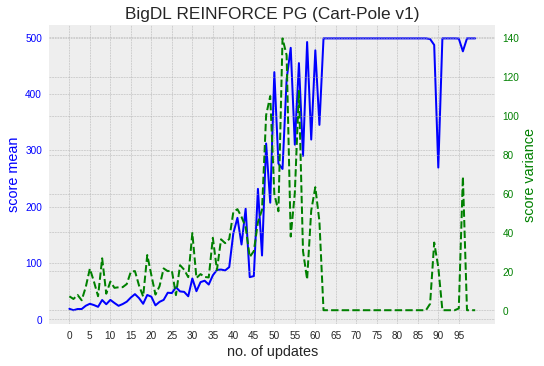

In [15]:
%matplotlib inline
import seaborn
plt.style.use('bmh')
arr = np.asarray(record)
print arr.shape
fig, ax1 = plt.subplots()
ind=np.arange(0,arr.shape[0],1)
#t = np.arange(0.01, 10.0, 0.01)
#s1 = np.exp(t)
ax1.plot(ind,arr[:,0], 'b-')
ax1.set_xlabel('no. of updates')
ax1.set_xticks(ind[::5])
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('score mean', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(ind,arr[:,1], 'g--')
ax2.set_ylabel('score variance', color='g')
ax2.tick_params('y', colors='g')
plt.grid(True)
#fig.tight_layout()
plt.title('BigDL REINFORCE PG (Cart-Pole v1)');

## Torch TWRL REINFORCE PG results

In [ ]:
folderpath = '/home/shane/torch-twrl/examples/rundata-pg-cartpole-v1-2000-5'
summaries = {}
for i in range(10,2001,10):
    summary = torchfile.load(folderpath+'/summary-'+str(i)+'.t7')
    summaries[i] = summary

In [ ]:
sums = []
for ep, s in sorted(summaries.items()):
    sums.append([ep, s['meanEpRewardWindow'],s['meanEpReward'],s['stdEpRewardWindow'],s['stdEpReward']])

In [ ]:
sums_array = np.array(sums)

In [ ]:
plt.style.use('bmh')

fig, ax1 = plt.subplots()
ind=sums_array[:,0]
#t = np.arange(0.01, 10.0, 0.01)
#s1 = np.exp(t)
ax1.plot(ind,sums_array[:,1],'b-',label='mean ep reward every 10 episodes')
ax1.plot(ind,sums_array[:,2],'r-',label='mean ep reward all previous episodes')
ax1.set_xlabel('episodes')
ax1.legend()
ax1.set_ylim(0,510)
#ax1.set_xticks(ind[::20])
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('score mean', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(ind,sums_array[:,3], 'g--')
ax2.set_ylabel('score std', color='g')
ax2.tick_params('y', colors='g')
plt.grid(True)
#fig.tight_layout()
plt.title('Twitter\'s Torch REINFORCE (Cart-Pole v1)')

### Appendix: Other Utility Fuctions and Debug code

In [ ]:
from bigdl.dataset.transformer import Sample
from bigdl.nn.layer import *
from bigdl.util.common import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *

from rl.criterion import *

init_engine()
criterion = RFPGCriterion()

In [ ]:
input = bigdl_input
target = bigdl_target
print input.shape, target.shape
loss = criterion.forward(input,target)
print "loss=",loss
gradient= criterion.backward(input, target)
print "gradient="
print gradient

In [ ]:
def prepare_traj(history,trajs):
    start_eps = history.num_eps()
    total_steps = 0
    for traj in trajs:
        actions  = np.array([ 0.])
        rewards = []
        states = np.array([0,0,0,0])
        for trans in traj:
            states = np.vstack((states, trans['state']))
            actions = np.vstack((actions,trans['action']))
            rewards.append(trans['reward'])
        num_steps = len(traj)
        history.add_traj(states[1:],np.squeeze(actions[1:]),np.squeeze(np.array(rewards)),num_steps)
        total_steps = total_steps + num_steps
    end_eps = history.num_eps()
    return start_eps, end_eps, total_steps

In [ ]:
def replay_torch_rundata(history,folderpath = '/home/shane/torch-twrl/examples/rundata'):
    allobserves = {}
    trajs = {}
    baselines = {}
    objs = {}
    grads = {}
    targets = {}
    trajLens = {}
    trajRets = {}
    advNorms = {}
    targets1s = {}
    fouts = {}
    allacts = {}
    advs = {}
    #iters = [1,2,3,4,5,7,8,9]
    iters = [4]
    for i in iters:
        observe = torchfile.load(folderpath+'/learn-allobserves-'+str(i)+'.t7')
        allobserves[i] = observe
    
        traj = torchfile.load(folderpath+'/learn-traj-'+str(i)+'.t7')
        trajs[i] = traj
    
        baseline = torchfile.load(folderpath+'/learn-baseline-'+str(i)+'.t7')
        baselines[i] = baseline
    
        grad = torchfile.load(folderpath+'/learn-grads-'+str(i)+'.t7')
        grads[i] = grad
    
        obj = torchfile.load(folderpath+'/learn-obj-'+str(i)+'.t7')
        objs[i] = obj
    
        target = torchfile.load(folderpath+'/learn-targets-'+str(i)+'.t7')
        targets[i] = target
    
        trajLen = torchfile.load(folderpath+'/learn-trajLengths-'+str(i)+'.t7')
        trajLens[i] = trajLen
    
        trajRet = torchfile.load(folderpath+'/learn-trajReturns-'+str(i)+'.t7')
        trajRets[i] = trajRet
    
        adv = torchfile.load(folderpath+'/learn-adv-'+str(i)+'.t7')
        advs[i] = adv
        
        advNorm = torchfile.load(folderpath+'/learn-advNorm-'+str(i)+'.t7')
        advNorms[i] = advNorm
    
        targets1 = torchfile.load(folderpath+'/learn-targets1-'+str(i)+'.t7')
        targets1s[i] = targets1
    
        fout = torchfile.load(folderpath+'/learn-forwardout-'+str(i)+'.t7')
        fouts[i] = fout
    
        allact = torchfile.load(folderpath+'/learn-allactions-'+str(i)+'.t7')
        allacts[i] = allact
    print "---------original advs---"
    print advs[4]
    print advs[4].shape
    print "---------original adv norms ------"
    print advNorms[4]
    print advNorms[4].shape
    return prepare_traj(history,trajs[4]),advs[4],advNorms[4]
    

\begin{align}
\frac{\partial L(P_{\theta}, R)}{\partial \theta} = (\frac{\frac{\partial L(P_{\theta}, R)}{\partial P_{\theta}} \odot P_{\theta}}{P_{\theta}})^T \frac{\partial P_{\theta}}{\partial \theta}
\end{align}